## Another introduction to Bayesian data analysis with PyStan

### Marianne Corvellec

*Institute for Globally Distributed Open Research and Education (IGDORE)*

<br>
<br>

<center>
    Seminar organized by Alberto Antonietti
    <br>
    DEIB
    <br>
    <b>Politecnico di Milano</b>
    <br><br>
    (Milan, Italy)
    <br><br>
    October 22<small><sup>nd</sup></small>, 2018
</center>

<center><img src="./images/igdore_logo.png" width="250"></center>

## Another introduction to Bayesian inference

1) Build a Bayesian statistical model

| Data $\mathcal{D}$ | Parameter $\theta$ | |
| --- | --- | --- |
| ![Likelihood](./images/likelihood_0.png) | ![Prior](./images/prior_0.png) | ![Posterior](./images/posterior_0.png) |

$\quad \textbf{likelihood} \; p(\mathcal{D} | \theta)$
$\quad \times \quad \qquad \textbf{prior} \; p(\theta)  \quad$
$\quad = \quad \textbf{posterior} \; p(\theta | \mathcal{D})$

2) Compute expectations

$$\mathbb{E}[a] = \int a(\theta) p(\theta | \mathcal{D}) \mathrm{d}\theta$$

(HMC, etc.)

## References

- Interest in Education and Assessment
  * Learning, evaluation, survey design and analysis
  * [The Carpentries](https://carpentries.org/assessment) (https://peer.asee.org/30960)
  * [Rochelle E. Tractenberg](https://neurology.georgetown.edu/faculty/tractenberg)'s work

- Reproducing Stan's education case study [DINA](http://mc-stan.org/users/documentation/case-studies/dina_independent.html) in Python (Seung Yeon Lee)
- Following the format of our [SciPy 2018 paper](http://conference.scipy.org/proceedings/scipy2018/vamvourellis_corvellec.html) "A Bayesian’s journey to a better research workflow" (Konstantinos Vamvourellis)

## What is Stan?

- It is a C++ compiled language for Bayesian statistical inference.
- You give the ingredients $\{ p(\mathcal{D}|\theta), p(\theta) \}$ (likelihood and prior),
  it gives you the posterior $p(\theta | \mathcal{D})$.

In practice,

- [PyStan](https://github.com/stan-dev/pystan): Python interface to Stan
- Stan resources online
  * Stan Manual [mc-stan.org/users/documentation](http://mc-stan.org/users/documentation)
  * Case Studies [mc-stan.org/users/documentation/case-studies](http://mc-stan.org/users/documentation/case-studies)
  * Forum [discourse.mc-stan.org](http://discourse.mc-stan.org)
- Similar tool: PyMC3

## Context and motivation

- The original work http://mc-stan.org/users/documentation/case-studies/dina_independent.html is copyrighted by Seung Yeon Lee and licensed under the 3-clause BSD and CC BY licenses (pro-sharing and attribution).

- This modified work lives at https://github.com/mkcor/py-repr-dina.

- The DINA model (Deterministic Input, Noisy And gate) belongs to the family of cognitive diagnosis models (CDM), which are used in educational measurement.

- Respondents (**students**) answer a questionnaire made of many **items**.

- The goal is to estimate students’ mastery of multiple latent traits, known as attributes or **skills**.

## 1) Scope the problem

Example: Skills relate to fraction subtraction. One skill is the ability to find a common denominator. An item requiring this skill could be "Compute $\frac{1}{2} - \frac{1}{3}$."
- $K$ skills
- $I$ items
- $J$ students

### Data

- $J \times I$ response matrix $Y$ where
  $y_{ji} = 1$ if student $j$ answered item $i$ correctly, $y_{ji} = 0$ otherwise;
- $I \times K$ Q-matrix $Q$ where
  $q_{ik} = 1$ if item $i$ requires skill $k$, $q_{ik} = 0$ otherwise.

### Estimate

- $J \times K$ matrix $R$ where $r_{jk}$ is the probability for student $j$ to master skill $k$.

- $K = 5$ skills
- $I = 15$ items
- $J = 536$ students

In [1]:
import pandas as pd

y = pd.read_csv('./../data/responses.csv')
Q = pd.read_csv('./../data/item_skill_Q.csv')

y.head()

,I01,I02,I03,I04,I05,I06,I07,I08,I09,I10,I11,I12,I13,I14,I15
0,0,1,0,1,0,1,1,1,1,1,1,0,1,1,1
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,0,0,0,0,1,1,1,0,0,0,0
3,1,1,1,0,0,1,1,1,1,0,1,0,1,0,1
4,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0


In [2]:
Q

,SK1,SK2,SK3,SK4,SK5
0,1,0,0,0,0
1,1,1,1,1,0
2,1,0,0,0,0
3,1,1,1,1,1
4,0,0,1,0,0
5,1,1,1,1,0
6,1,1,1,1,0
7,1,1,0,0,0
8,1,0,1,0,0
9,1,0,1,1,1


### Matrix $\alpha$ of skill profiles

There are $C = 2^K$ possible skill profiles. Skill mastery is a latent trait.

In [3]:
import itertools

# http://pandas.pydata.org/pandas-docs/version/0.14/cookbook.html#creating-example-data
def expand_grid(data_dict):
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys()) 

alpha = expand_grid(
    {'SK1': [0, 1],
     'SK2': [0, 1],
     'SK3': [0, 1],
     'SK4': [0, 1],
     'SK5': [0, 1]}
)
alpha

,SK1,SK2,SK3,SK4,SK5
0,0,0,0,0,0
1,0,0,0,0,1
2,0,0,0,1,0
3,0,0,0,1,1
4,0,0,1,0,0
5,0,0,1,0,1
6,0,0,1,1,0
7,0,0,1,1,1
8,0,1,0,0,0
9,0,1,0,0,1


In [4]:
I = Q.shape[0]
J = y.shape[0]
K = Q.shape[1]

assert y.shape[1] == I
assert alpha.shape[1] == K

C = 2**K
assert alpha.shape[0] == C
C

32

From $\alpha$ and $Q$, we can compute the global mastery indicator $\xi$. We are still at the latent level.

### Matrix $\xi$ as global mastery indicator


$\xi$ is $I \times C$.
For each item $i$, a given skill profile $c$ either masters all corresponding skills ($\xi_{ic} = 1$) or
does not ($\xi_{ic} = 0$).

$$\xi_{ic} = \prod_{k = 1}^{K} \alpha_{ck}^{q_{ik}}$$

![Toy alpha and Q matrices](./images/xi_toy_0.jpg)
![Building toy global mastery indicator](./images/xi_toy_1.jpg)

In [5]:
import numpy as np

xi = np.ones((I, C))

In [6]:
for profile in range(xi.shape[1]):
    for item in range(xi.shape[0]):
        for skill in range(alpha.shape[1]):
            xi[item, profile] *= alpha.iloc[profile, skill] ** Q.iloc[item, skill]
# "Vectorized is better than an explicit loop"... Sorry!
# Readability matters.

In [7]:
assert xi.max() == 1
assert xi.min() == 0

Now, a student might get item $i$ right even though they do not master all corresponding skills (guessing, $g_i$).
Likewise, they might get item $i$ wrong even if they do master all corresponding skills (slipping, $s_i$).

Then, the probability that item $i$ be responded correctly by a student with (latent) skill profile $c$
is given by: 

$$\pi_{ic} = (1 - s_i)^{\xi_{ic}} g_i^{(1 - \xi_{ic})}$$

## 2) Specify model, likelihood, and priors

We see the model as a data generation process.

In [8]:
with open('models/dina_nostructure.stan', 'r') as file:
    model_spec = file.read()
    print(model_spec)

data {
  int<lower=1> I;			// # of items
  int<lower=1> J;			// # of respondents	
  int<lower=1> K;			// # of attributes
  int<lower=1> C;			// # of attribute profiles (latent classes)	
  matrix[J,I] y;			// response matrix
  matrix[C,K] alpha;		// attribute profile matrix
  matrix[I,C] xi;			// the global attribute mastery indicator (product of alpha^q-element)
}

parameters {
  simplex[C] nu; 					    // probabilities of latent class membership
  real<lower=0,upper=1> slip[I];		// slip parameter	
  real<lower=0,upper=1> guess[I];		// guess parameter
}

transformed parameters {
  vector[C] log_nu = log(nu);
}

model {
  real ps[C];				// temp for log component densities
  matrix[I,C] pi;
  real log_items[I];
  slip ~ beta(5,25);
  guess ~ beta(5,25);
  for (c in 1:C){
    for (i in 1:I){
      pi[i,c] = (1 - slip[i])^xi[i,c] * guess[i]^(1 - xi[i,c]);
    }
  }
  for (j in 1:J){
    for (c in 1:C){
      for (i in 1:I){
        log_items[i] = y[j,i] * log(pi[i,c]) + (1 - y[j,i]) * log(

In [9]:
print(model_spec[int(len(model_spec)/3.3):])

 log(nu);
}

model {
  real ps[C];				// temp for log component densities
  matrix[I,C] pi;
  real log_items[I];
  slip ~ beta(5,25);
  guess ~ beta(5,25);
  for (c in 1:C){
    for (i in 1:I){
      pi[i,c] = (1 - slip[i])^xi[i,c] * guess[i]^(1 - xi[i,c]);
    }
  }
  for (j in 1:J){
    for (c in 1:C){
      for (i in 1:I){
        log_items[i] = y[j,i] * log(pi[i,c]) + (1 - y[j,i]) * log(1 - pi[i,c]);
      }
      ps[c] = log_nu[c] + sum(log_items);	
    }
    target += log_sum_exp(ps);
  }
}

generated quantities {
  matrix[J,C] prob_resp_class;		// posterior probabilities of respondent j being in latent class c 
  matrix[J,K] prob_resp_attr;		// posterior probabilities of respondent j being a master of attribute k 
  matrix[I,C] pi;
  real log_items[I];
  row_vector[C] prob_joint;
  real prob_attr_class[C];
  for (c in 1:C){
    for (i in 1:I){
      pi[i,c] = (1 - slip[i])^xi[i,c] * guess[i]^(1 - xi[i,c]);
    }
  }
  for (j in 1:J){
    for (c in 1:C){
      for (i in 1:I){
   

In [10]:
import pystan as stan

stan.__version__

'2.18.0.0'

In [11]:
sm = stan.StanModel(model_code=model_spec, verbose=True)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3f654cbe043a670df0504931f5ee3db8 NOW.
INFO:pystan:OS: linux, Python: 3.7.0 (default, Oct  9 2018, 10:31:47) 
[GCC 7.3.0], Cython 0.28.5


Compiling /tmp/tmpjc5d1rx4/stanfit4anon_model_3f654cbe043a670df0504931f5ee3db8_4977506116119766214.pyx because it changed.
[1/1] Cythonizing /tmp/tmpjc5d1rx4/stanfit4anon_model_3f654cbe043a670df0504931f5ee3db8_4977506116119766214.pyx
building 'stanfit4anon_model_3f654cbe043a670df0504931f5ee3db8_4977506116119766214' extension
creating /tmp/tmpjc5d1rx4/tmp
creating /tmp/tmpjc5d1rx4/tmp/tmpjc5d1rx4
/home/marianne/miniconda3/envs/dina/bin/x86_64-conda_cos6-linux-gnu-cc -DNDEBUG -fwrapv -O2 -Wall -Wstrict-prototypes -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -pipe -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -fPIC -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -I/tmp/tmpjc5d1rx4 -I/home/marianne/miniconda3/envs/dina/lib/python3.7/site-packages/pystan -I/home/marianne/miniconda3/envs/dina/lib/python3.7/site-packages/pystan/stan/src -I/home/marianne/miniconda3/envs/dina/lib/python3.7/site-packages/pystan/stan/lib/stan_math -I/home/mari

## 3) Generate synthetic data

Let us simulate data generation for $20$ items, $5$ skills, and $500$ students.

In [12]:
I_s = 20  # items
K_s = 5  # skills
Q_s = np.zeros((I_s, K_s))

J_s = 500  # students
C_s = C  # profiles

In [13]:
Q_s[[1, 4, 5, 6, 14, 18], 0] = 1
Q_s[[3, 6, 8, 9, 10, 12, 13], 1] = 1
Q_s[15:20, 1] = 1
Q_s[[4, 5, 12], 2] = 1
Q_s[1:3, 2] = 1
Q_s[[2, 3, 7, 9, 10], 3] = 1
Q_s[16:20, 3] = 1
Q_s[[1, 3, 4, 9, 11, 18, 19], 4] = 1
# Watch out: Array slicing != DataFrame slicing

In [14]:
Q_s

array([[0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 1.],
       [1., 0., 1., 0., 1.],
       [1., 0., 1., 0., 0.],
       [1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 1.],
       [0., 1., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 0.],
       [1., 1., 0., 1., 1.],
       [0., 1., 0., 1., 1.]])

In [15]:
alpha_s = alpha
alpha_s

,SK1,SK2,SK3,SK4,SK5
0,0,0,0,0,0
1,0,0,0,0,1
2,0,0,0,1,0
3,0,0,0,1,1
4,0,0,1,0,0
5,0,0,1,0,1
6,0,0,1,1,0
7,0,0,1,1,1
8,0,1,0,0,0
9,0,1,0,0,1


In [16]:
alpha_prob = np.array([0.01344, 0.00576, 0.02016, 0.00864, 0.05376,
                       0.02304, 0.08064, 0.03456, 0.00336, 0.00144,
                       0.00504, 0.00216, 0.01344, 0.00576, 0.02016,
                       0.00864, 0.03136, 0.01344, 0.04704, 0.02016,
                       0.12544, 0.05376, 0.18816, 0.08064, 0.00784,
                       0.00336, 0.01176, 0.00504, 0.03136, 0.01344,
                       0.04704, 0.02016])

In [17]:
# Generate actual skill profiles
A = alpha_s.sample(J_s, replace=True, weights=alpha_prob)
A.head(3)
# TODO Seed!!!

,SK1,SK2,SK3,SK4,SK5
6,0,0,1,1,0
14,0,1,1,1,0
31,1,1,1,1,1


In [18]:
A.describe()

,SK1,SK2,SK3,SK4,SK5
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.668000,0.214000,0.786000,0.642000,0.270000
std,0.471403,0.410538,0.410538,0.479892,0.444404
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
slip_s = np.array([15, 16, 9, 14, 19, 12, 22, 16, 14, 26, 12, 18, 20, 13, 9, 29, 30, 24, 9, 27]) * 0.01
guess_s = np.array([9, 15, 12, 20, 8, 10, 17, 25, 28, 15, 7, 27, 10, 5, 25, 13, 25, 17, 11, 16]) * 0.01

In [20]:
# Compute global mastery indicator for students (actual profiles)
xi_s = np.ones((I_s, J_s))

for profile in range(J_s):
    for item in range(I_s):
        for skill in range(K_s):
            xi_s[item, profile] *= A.iloc[profile, skill] ** Q_s[item, skill]
# Watch out: Array indexing != DataFrame indexing

In [21]:
assert xi_s.max() == 1
assert xi_s.min() == 0

Based on the actual mastery of skills by these 500 (synthetic) students, we can generate the probability for them to answer items correctly.

In [22]:
pi_s = np.ones((I_s, J_s))
y_s = np.ones((J_s, I_s))

In [23]:
for profile in range(J_s):
    for item in range(I_s):
        pi_s[item, profile] = (1 - slip_s[item])**xi_s[item, profile] * guess_s[item]**(1 - xi_s[item, profile])
        # Sample responses (data) from Bernoulli distribution with success probability above
        y_s[profile, item] = np.random.binomial(1, pi_s[item, profile])

The model requires the (class) profile-based global mastery indicator $\xi$.

In [24]:
xi_class_s = np.ones((I_s, C_s))

for profile in range(C_s):
    for item in range(I_s):
        for skill in range(K_s):
            xi_class_s[item, profile] *= alpha.iloc[profile, skill] ** Q_s[item, skill]
# It would be about time to write a function!

## 4) Fit model to the synthetic data

Pass data to model via a dictionary.

In [25]:
synt_data = {
    'I': I_s,
    'J': J_s,
    'K': K_s,
    'C': C_s,
    'y': y_s,
    'alpha': alpha_s, 
    'xi': xi_class_s
}

In [26]:
fit_synt = sm.sampling(data=synt_data, iter=1000, chains=4)

In [27]:
print(stan.misc.stansummary(fit_synt, pars=['guess']))

Inference for Stan model: anon_model_3f654cbe043a670df0504931f5ee3db8.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
guess[1]    0.17  1.3e-3   0.07   0.06   0.12   0.16   0.21   0.31   2502    1.0
guess[2]    0.14  3.7e-4   0.02    0.1   0.12   0.14   0.15   0.17   2405    1.0
guess[3]    0.15  7.5e-4   0.03   0.08   0.12   0.14   0.17   0.21   1994    1.0
guess[4]    0.23  3.6e-4   0.02   0.19   0.21   0.23   0.24   0.27   2607    1.0
guess[5]    0.09  3.2e-4   0.02   0.06   0.08   0.09    0.1   0.13   2477    1.0
guess[6]    0.08  5.4e-4   0.03   0.04   0.06   0.08    0.1   0.14   2449    1.0
guess[7]    0.16  3.6e-4   0.02   0.13   0.15   0.16   0.18    0.2   2513    1.0
guess[8]    0.25  9.9e-4   0.04   0.16   0.22   0.25   0.28   0.34   1975    1.0
guess[9]    0.25  4.6e-4   0.02   0.21   0.24   0.25   0.27   0.29   2171    1.0
gue

### Model fit checks

In [28]:
guess_s[:5]

array([0.09, 0.15, 0.12, 0.2 , 0.08])

In [29]:
post_samples_synt = fit_synt.extract(permuted=True)
df = pd.DataFrame(post_samples_synt['guess'])

In [30]:
df.loc[:, :4]

,0,1,2,3,4
0,0.167184,0.151159,0.110023,0.241166,0.091021
1,0.209224,0.157752,0.113288,0.218415,0.098927
2,0.193565,0.139308,0.123642,0.253708,0.091815
3,0.190031,0.158430,0.145637,0.230306,0.084328
4,0.107701,0.118938,0.228948,0.186522,0.101282
5,0.175214,0.128321,0.108411,0.241014,0.133247
6,0.146329,0.126774,0.148772,0.248730,0.086220
7,0.242501,0.164853,0.193500,0.238208,0.073283
8,0.204161,0.151795,0.175449,0.243246,0.084360
9,0.171837,0.160474,0.144341,0.204017,0.109716


In [31]:
import matplotlib.pyplot as plt

%matplotlib inline

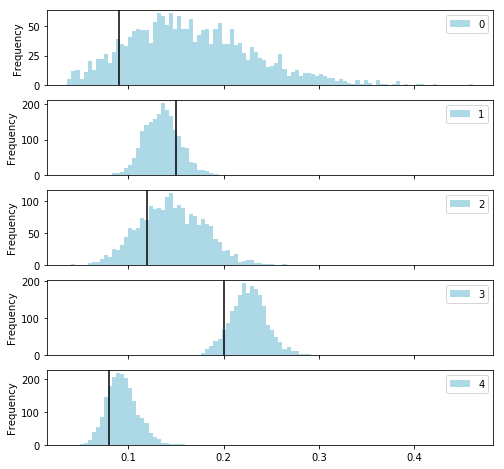

In [32]:
ax = df.loc[:, :4].plot.hist(subplots=True, color='lightblue', bins=100, figsize=(8, 8));

for i in range(5):
    ax[i].axvline(guess_s[i], color='black');

## 5) Fit model to the real data

In [33]:
real_data = {
    'I': I,
    'J': J,
    'K': K,
    'C': C,
    'y': y,
    'alpha': alpha, 
    'xi': xi
}

In [34]:
fit_real = sm.sampling(data=real_data, iter=1000, chains=4)

In [35]:
import pickle

pickle.dump(fit_real.extract(permuted=True), open('./../data/interim/post_samples.pkl', 'wb'))

In [36]:
post_samples = pickle.load(open('./../data/interim/post_samples.pkl', 'rb'))

In [37]:
post_samples.keys()

odict_keys(['nu', 'slip', 'guess', 'log_nu', 'prob_resp_class', 'prob_resp_attr', 'pi', 'log_items', 'prob_joint', 'prob_attr_class', 'lp__'])

In [38]:
student_mastery = post_samples['prob_resp_attr']
student_mastery.shape

(2000, 536, 5)

In [39]:
[student_mastery[:, :, i].mean() for i in range(student_mastery.shape[2])]

[0.7922718544548545,
 0.8237782229983325,
 0.8086499641296334,
 0.6068188795366777,
 0.6326693582212178]

## Thank you!

### Further reading and watching

- Statistical Rethinking by Richard McElreath

- Bayesian Data Analysis 3 by Andrew Gelman *et al.*

- Stan’s YouTube channel